<a href="https://colab.research.google.com/github/OverfittingUnderachiever/RL-Lab/blob/main/dqn_Rainbow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DQN + Rainbow
By Henry Frey, Vanessa Stöckl, Seif Saleh, Yi-Chieh Lin

RL lab homework DQN notebook used as base: Prof. Joschka Bödecker, Julien Brosseit

## 0 Setup
These are the same packages as in the last exercise:

In [1084]:
!pip install torch torchvision torchaudio
!pip install gymnasium==0.29.1
!pip install minatar==1.0.15
!pip install matplotlib
!pip install imageio

In [1085]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import copy
import numpy as np
import pandas as pd
import random
from PIL import Image
import gymnasium as gym
import matplotlib.pyplot as plt
from typing import Callable
from collections import namedtuple
import itertools


## 1 Deep Q-Networks
Remember, in Q-learning, we have the following update:

$Q(s,a) \leftarrow Q(s,a) + \alpha (r + \gamma \max_{a'}Q(s', a') - Q(s, a))$

with discount factor $\gamma$, learning rate $\alpha$, reward $r$, sampled state $s$, sampled next state $s'$ and sampled action $a$. Instead of a table, we will now use a neural network to represent the Q-function $Q(s, a; \theta)$, where $\theta$ are the parameters of the neural network. In order to learn the Q-function, we minimize the Mean Squared Error loss between our current estimate and our TD target using Stochastic gradient descent (SGD):

$ L(\theta) = \mathop{{}\mathbb{E}}_{(s, a, r, s') \sim D}([r + \gamma \max_{a'}Q(s', a'; \theta') - Q(s, a; \theta)]^2 )$  

where D is a dataset of sampled transitions and $\theta'$ are old parameters. This is very similar to how we train in a supervised learning setting!



## 1.1 Q-Network

Since we are representing our Q-function as a deep neural network, we will first define it using PyTorch. Then we will define the epsilon greedy policy and introduce how to decay the epsilon over time.

---


In the DQN paper, the network structure used is described as follows (although we have changed the hyperparameters!):
> The input to the neural network consists [..] [of] an 10 × 10 × n image [...]. The first hidden layer convolves 16 5 × 5
> filters with stride 1 with the input image and applies a rectifier nonlinearity. The second
> hidden layer convolves 32 3 × 3 filters with stride 1, again followed by a rectifier nonlinearity. The
> final hidden layer is fully-connected and consists of 128 rectifier units. The output layer is a fully-
> connected linear layer with a single output for each valid action.

<span style="color:orange">**DQN**</span>

In [1086]:
class NoisyLinear(nn.Module):
    """
    Noisy Linear Layer with Factorized Gaussian Noise
    """
    def __init__(self, in_features: int, out_features: int, sigma_init: float = 0.017):
        super(NoisyLinear, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.sigma_init = sigma_init

        # Learnable parameters
        self.mu_weight = nn.Parameter(torch.empty(out_features, in_features))
        self.sigma_weight = nn.Parameter(torch.empty(out_features, in_features))
        self.mu_bias = nn.Parameter(torch.empty(out_features))
        self.sigma_bias = nn.Parameter(torch.empty(out_features))

        # Initialize parameters
        self.reset_parameters()

    def reset_parameters(self):
        """Initialize the parameters of the layer"""
        mu_range = 1.0 / np.sqrt(self.in_features)
        
        self.mu_weight.data.uniform_(-mu_range, mu_range)
        self.sigma_weight.data.fill_(self.sigma_init / np.sqrt(self.in_features))
        self.mu_bias.data.uniform_(-mu_range, mu_range)
        self.sigma_bias.data.fill_(self.sigma_init / np.sqrt(self.out_features))

    def _scale_noise(self, size: int) -> torch.Tensor:
        """Generate scaled noise for input or output features"""
        x = torch.randn(size, device=self.mu_weight.device)
        return x.sign().mul(x.abs().sqrt())

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass with noise sampling"""
        if self.training:
            # Generate new random noise
            epsilon_in = self._scale_noise(self.in_features)
            epsilon_out = self._scale_noise(self.out_features)

            # Outer product of noise
            weight_epsilon = epsilon_out.unsqueeze(1) * epsilon_in.unsqueeze(0)
            bias_epsilon = epsilon_out

            # Combine weights with noise
            weight = self.mu_weight + self.sigma_weight * weight_epsilon
            bias = self.mu_bias + self.sigma_bias * bias_epsilon
        else:
            weight = self.mu_weight
            bias = self.mu_bias

        return F.linear(x, weight, bias)

    def extra_repr(self) -> str:
        """String representation"""
        return f'in_features={self.in_features}, out_features={self.out_features}'
class DQN(nn.Module):
    def __init__(self, obs_shape: torch.Size, num_actions: int):
        """
        Initialize the DQN network with Noisy Nets.

        :param obs_shape: Shape of the observation space
        :param num_actions: Number of actions
        """
        super(DQN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(obs_shape[-1], 16, stride=1, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, stride=1, kernel_size=3)

        # Noisy Linear layers
        self.noisy_fc1 = NoisyLinear(32 * 4 * 4, 128)
        self.noisy_fc2 = NoisyLinear(128, num_actions)

        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Reorder the input to (batch_size, channels, height, width)
        x = x.permute(0, 3, 1, 2)

        # Convolutional layers
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))

        # Flatten for fully connected layers
        x = torch.flatten(x, 1)

        # Noisy layers
        x = self.relu(self.noisy_fc1(x))
        out = self.noisy_fc2(x)

        return out


In [1087]:
# Test

# Create dummy input
x_dummy = torch.randn(1, 10, 10, 4)  # Batch size = 1, height = 10, width = 10, channels = 4
dqn = DQN(x_dummy.shape, 4)  # 4 actions in the output

# Check output shape
assert dqn(x_dummy).shape == (1, 4), f"Expected output shape (1, 4) but got {dqn(x_dummy).shape}"

### BEGIN HIDDEN TESTS
# Check whether the network has two conv layers
assert len([m for m in dqn.modules() if isinstance(m, nn.Conv2d)]) == 2, "Expected 2 Conv2d layers"

# Check whether the network has two NoisyLinear layers
assert len([m for m in dqn.modules() if isinstance(m, NoisyLinear)]) == 2, "Expected 2 NoisyLinear layers"
### END HIDDEN TESTS


We import the epsilon greedy policy from our previous exercise. Note that we made some changes because Q is a network and epsilon is no longer fixed.


<span style="color:orange">**Policy**</span>

In [1088]:
def make_epsilon_greedy_policy(Q: nn.Module, num_actions: int):
    """
    Creates an epsilon-greedy policy with proper device and shape handling.
    """
    def policy_fn(obs: torch.Tensor, epsilon: float = 0.0):
        if np.random.uniform() < epsilon:
            return np.random.randint(0, num_actions)
        
        with torch.no_grad():
            # Ensure batch dimension
            if obs.dim() == 3:
                obs = obs.unsqueeze(0)
            q_values = Q(obs)
            return q_values.argmax(dim=1).item()

    return policy_fn


In [1089]:
def linear_epsilon_decay(eps_start: float, eps_end: float, current_timestep: int, duration: int) -> float:
    """
    Linear decay of epsilon.

    :param eps_start: The initial epsilon value.
    :param eps_end: The final epsilon value.
    :param current_timestep: The current timestep.
    :param duration: The duration of the schedule (in timesteps). So when schedule_duration == current_timestep, eps_end should be reached

    :returns: The current epsilon.
    """

    # TODO: Your code here
    ### BEGIN SOLUTION
    ratio = min(1.0, current_timestep / duration)
    return (eps_start - eps_end) * (1 - ratio) + eps_end
    ### END SOLUTION


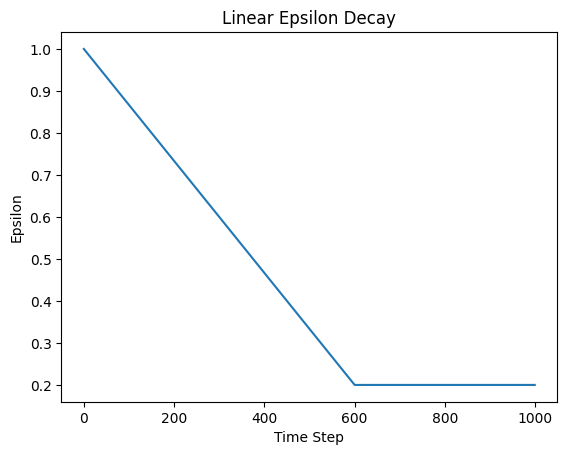

In [1090]:
import matplotlib.pyplot as plt

eps_start = 1.0
eps_end = 0.2
schedule_duration = 1000

eps_values = [linear_epsilon_decay(eps_start, eps_end, t, 600) for t in range(schedule_duration)]

plt.plot(range(schedule_duration), eps_values)
plt.xlabel('Time Step')
plt.ylabel('Epsilon')
plt.title('Linear Epsilon Decay')
plt.show()
### BEGIN HIDDEN TESTS
assert eps_values[0] == eps_start, "Expected eps_values[0] to be eps_start"
assert eps_values[-1] == eps_end, "Expected eps_values[-1] to be eps_end"
assert len(eps_values) == schedule_duration, "Expected eps_values to have length schedule_duration"
assert np.abs(eps_values[300] - 0.6) < 1e-10, "Expected eps_values[600] to be 0.6"
assert eps_values[600] == 0.2, "Expected eps_values[600] to be 0.6"
### END HIDDEN TESTS


## 1.2 Target Network and Replay Buffer
As described before, the main idea behind DQN is simple, we just minimize the MSE between the TD-target and the current estimate using the transitions we sampled. However, there are two problems that make the method very unstable:

1. **Non-stationary target**: The TD-target uses an estimate from our Q-network. Unlike supervised learning, this target is not fixed, and whenever we update our network parameters, the target changes as well.
2. Sampled transitions are **correlated** (each transition depends on the last transition if both are from the same episode). Samples are not independent.

DQNs addresses both problems by using

1. **Target networks:**
An older set of network parameters is stored to compute the TD target, so they change less frequently and this improves stability. We call this network the target network. Its parameters are updated every few iterations.
2. **Experience Replay:**
A buffer where all transitions are stored and randomly sampled to make the data distribution more stationary. The buffer has a fixed size and new samples overwrite old ones.

First we look at the target network:

In [1091]:
"""

# Create dummy input
test_input = torch.tensor([[1, 2, 3, 4]], dtype=torch.float32)

# Define the network with NoisyLinear layers
net = nn.Sequential(
    NoisyLinear(4, 3),
    nn.ReLU(),
    NoisyLinear(3, 1)
)

# Before modifying the parameters
print(f"Prediction (Before): {net(test_input)}\n")

# Save the parameters
params = copy.deepcopy(net.state_dict())

print("Parameters:")
for key, value in params.items():
    print(f"- Parameter {key}:\n{value}")

# Modify weight_mu of the first NoisyLinear layer
net[0].weight_mu.data.fill_(0.0)
print(f"\nPrediction (After change): {net(test_input)}\n")

# Reload the old parameters
net.load_state_dict(params)
print(f"Prediction (After reload): {net(test_input)}\n")
"""

'\n\n# Create dummy input\ntest_input = torch.tensor([[1, 2, 3, 4]], dtype=torch.float32)\n\n# Define the network with NoisyLinear layers\nnet = nn.Sequential(\n    NoisyLinear(4, 3),\n    nn.ReLU(),\n    NoisyLinear(3, 1)\n)\n\n# Before modifying the parameters\nprint(f"Prediction (Before): {net(test_input)}\n")\n\n# Save the parameters\nparams = copy.deepcopy(net.state_dict())\n\nprint("Parameters:")\nfor key, value in params.items():\n    print(f"- Parameter {key}:\n{value}")\n\n# Modify weight_mu of the first NoisyLinear layer\nnet[0].weight_mu.data.fill_(0.0)\nprint(f"\nPrediction (After change): {net(test_input)}\n")\n\n# Reload the old parameters\nnet.load_state_dict(params)\nprint(f"Prediction (After reload): {net(test_input)}\n")\n'

So we can save and load old parameters of our network using ``.state_dict()`` and ``.load_state_dict(..)`` respectively.

---
<span style="color:orange">**Replay Buffer**</span>

The replay buffer stores transitions of the form $(s, a, r, s')$ with $s$ as the current state, the action $a$, the reward $r$, and the next state $s'$. The buffer can perform two operations:
- **store**: During sampling we observe transitions and store them with ``buffer.store(...)``. However, the buffer only has a fixed size
(as we cannot store an infinte amount of data). When reaching it, the oldest samples are overwritten first.
- **sample**: For training, we want to sample a batch of transitions from our buffer via ``buffer.sample(...)``. The transitions are sampled uniformly and with replacement i.e. the same transition can be sampled more than once.



In [1092]:
class NStepReplayBuffer:
    def __init__(self, max_size: int, n_step: int = 3, gamma: float = 0.99):
        """
        Create the n-step replay buffer.

        :param max_size: Maximum number of transitions in the buffer
        :param n_step: Number of steps to accumulate rewards over
        :param gamma: Discount factor
        """
        """
        Create the n-step replay buffer.

        :param max_size: Maximum number of transitions in the buffer
        :param n_step: Number of steps to accumulate rewards over
        :param gamma: Discount factor
        """
        self.data = []
        self.max_size = max_size
        self.position = 0
        self.n_step = n_step
        self.gamma = gamma

        # Buffer for building n-step transitions
        self.temp_buffer = []

    def _get_n_step_info(self):
        """Calculate n-step reward and next state"""
        # Get the first (oldest) transition
        first = self.temp_buffer[0]

        # Calculate n-step reward
        n_step_reward = 0
        for i in range(self.n_step):
            if i >= len(self.temp_buffer):
                break
            n_step_reward += (self.gamma ** i) * self.temp_buffer[i][2]  # index 2 is reward

            # If episode terminated, don't include future rewards
            if self.temp_buffer[i][4]:  # index 4 is terminated flag
                break

        # Get the n-th next state and done flag
        if len(self.temp_buffer) >= self.n_step:
            next_state = self.temp_buffer[self.n_step - 1][3]  # index 3 is next_state
            done = self.temp_buffer[self.n_step - 1][4]
        else:
            next_state = self.temp_buffer[-1][3]
            done = self.temp_buffer[-1][4]

        return n_step_reward, next_state, done

    def __len__(self) -> int:
        """Returns how many transitions are currently in the buffer."""
        return len(self.data)

    def store(self, obs: torch.Tensor, action: torch.Tensor, reward: torch.Tensor,
              next_obs: torch.Tensor, terminated: torch.Tensor):
        """
        Adds a new transition to the buffer.

        :param obs: The current observation
        :param action: The action
        :param reward: The reward
        :param next_obs: The next observation
        :param terminated: Whether the episode terminated
        """
        # Add transition to temporary buffer
        self.temp_buffer.append((obs, action, reward, next_obs, terminated))

        # If we have enough transitions, compute n-step transition
        if len(self.temp_buffer) >= self.n_step:
            n_step_reward, next_state, done = self._get_n_step_info()
            first_transition = self.temp_buffer[0]

            # Store the n-step transition
            transition = (
                first_transition[0],  # observation
                first_transition[1],  # action
                n_step_reward,        # n-step cumulative reward
                next_state,           # n-step next state
                done                  # done flag
            )

            if len(self.data) < self.max_size:
                self.data.append(transition)
            else:
                self.data[self.position] = transition

            self.position = (self.position + 1) % self.max_size

            # Remove the oldest transition
            self.temp_buffer.pop(0)

        # Clear temp buffer if episode terminated
        if terminated:
            while len(self.temp_buffer) > 0:
                n_step_reward, next_state, done = self._get_n_step_info()
                first_transition = self.temp_buffer[0]

                transition = (
                    first_transition[0],
                    first_transition[1],
                    n_step_reward,
                    next_state,
                    done
                )

                if len(self.data) < self.max_size:
                    self.data.append(transition)
                else:
                    self.data[self.position] = transition
                self.position = (self.position + 1) % self.max_size

                self.temp_buffer.pop(0)

    def sample(self, batch_size: int) -> torch.Tensor:
        """
        Sample a batch of n-step transitions.

        :param batch_size: The batch size
        :returns: Tuple of tensors (obs_batch, action_batch, reward_batch, next_obs_batch, terminated_batch)
        """
        return [torch.stack(b) for b in zip(*random.choices(self.data, k=batch_size))]

<span style="color:orange">**Prioritized Experience Replay**</span>

In [1093]:
class PrioritizedExperienceReplay(NStepReplayBuffer):
    def __init__(self, max_size: int, n_step: int = 3, gamma: float = 0.99, alpha: float = 0.6, beta: float = 0.4, eps: float = 1e-6):
        self.max_size = max_size
        self.n_step = n_step
        self.gamma = gamma
        self.alpha = alpha
        self.beta = beta
        self.eps = eps
        self.priorities = np.zeros(max_size)
        self.data = []
        self.pos = 0
        self.temp_buffer = []

    def store(self, obs: torch.Tensor, action: torch.Tensor, reward: torch.Tensor, 
              next_obs: torch.Tensor, terminated: torch.Tensor):
        transition = (obs, action, reward, next_obs, terminated)
        if len(self.data) < self.max_size:
            self.data.append(transition)
        else:
            self.data[self.pos] = transition
            
        max_prio = self.priorities.max() if self.priorities.max() > 0 else 1.0
        self.priorities[self.pos] = max_prio
        self.pos = (self.pos + 1) % self.max_size

    def sample(self, batch_size: int):
        if len(self.data) == self.max_size:
            prios = self.priorities
        else:
            prios = self.priorities[:len(self.data)]
            
        probs = (prios + self.eps) ** self.alpha
        probs /= probs.sum()
        
        indices = np.random.choice(len(self.data), batch_size, p=probs)
        weights = (len(self.data) * probs[indices]) ** (-self.beta)
        weights /= weights.max()
        
        samples = [self.data[idx] for idx in indices]
        batch = [torch.stack(b) for b in zip(*samples)]
        batch.append(torch.tensor(indices))
        batch.append(torch.tensor(weights, dtype=torch.float32))
        
        return batch

    def update(self, priorities: list, indices: list):
        for idx, prio in zip(indices, priorities):
            self.priorities[idx] = abs(prio) + self.eps

    def __len__(self):
        return len(self.data)

## 1.3 Algorithm
In this section, we will first look at the update of the DQN and then implement the entire algorithm.

---
<span style="color:orange">**DQN Update**</span>


In [1094]:
def update_dqn_nstep(
        q: nn.Module,
        q_target: nn.Module,
        optimizer: optim.Optimizer,
        gamma: float,
        n_step: int,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
        weights: torch.Tensor = None,
    ):
    """
    Update the DQN network using n-step returns and Double Q-Learning with Noisy Nets.

    :param q: The DQN network (with noise)
    :param q_target: The target DQN network (with noise)
    :param optimizer: The optimizer
    :param gamma: The discount factor
    :param n_step: Number of steps for n-step return
    :param obs: Batch of current observations
    :param act: Batch of actions
    :param rew: Batch of n-step returns
    :param next_obs: Batch of n-step next observations
    :param tm: Batch of termination flags
    """
    # Zero out the gradient
    optimizer.zero_grad()

    # Calculate the n-step TD-Target using Double Q-Learning with Noisy Nets
    with torch.no_grad():
        # Use the online network (q) to select the action
        next_action = q(next_obs).argmax(dim=1)

        # Get the Q-values from the target network (q_target)
        next_q_values = q_target(next_obs)
        # Get the Q-value corresponding to the action selected by the online network
        next_q_value = next_q_values.gather(1, next_action.unsqueeze(1)).squeeze(1)

        # Calculate the n-step TD Target
        td_target = rew + (gamma ** n_step) * next_q_value * (1 - tm.float())

    # Calculate current Q-values and loss using noisy network
    current_q_values = q(obs)
    current_q_value = current_q_values.gather(1, act.unsqueeze(1))

    td_error = (current_q_value - td_target.unsqueeze(1)).abs()
    
    if weights is not None:
        loss = (weights.unsqueeze(1) * td_error ** 2).mean()
    else:
        loss = td_error.pow(2).mean()

    # Backpropagate the loss and step the optimizer
    loss.backward()
    optimizer.step()

    return td_error.squeeze(), current_q_values

<span style="color:orange">**Categorical DQN**</span>

In [1095]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])


class CategoricalDQN(nn.Module):
    def __init__(self, obs_shape: torch.Size, num_actions: int, n_atoms=51, v_min=-10, v_max=20):
        super().__init__()
        
        self.n_atoms = n_atoms
        self.v_min = v_min
        self.v_max = v_max
        self.support = nn.Parameter(torch.linspace(v_min, v_max, n_atoms), requires_grad=False)
        
        # Input shape handling
        self.input_channels = obs_shape[-1]
        self.input_height = obs_shape[0]
        self.input_width = obs_shape[1]
        
        # Larger network architecture
        self.conv1 = nn.Conv2d(self.input_channels, 32, stride=1, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, stride=1, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Calculate conv output size
        conv_output_size = self._get_conv_output_size()
        
        # Wider fully connected layers
        self.noisy_fc1 = NoisyLinear(conv_output_size, 512)
        self.noisy_fc2 = NoisyLinear(512, num_actions * n_atoms)
        
        self.relu = nn.ReLU()
        self.num_actions = num_actions
        
        # Initialize weights with smaller values
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Conv2d):
            nn.init.orthogonal_(module.weight, gain=0.1)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Linear):
            nn.init.orthogonal_(module.weight, gain=0.1)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, NoisyLinear):
            nn.init.orthogonal_(module.mu_weight, gain=0.1)
            nn.init.constant_(module.sigma_weight, 0.017)
            if module.mu_bias is not None:
                module.mu_bias.data.zero_()
                module.sigma_bias.data.fill_(0.017)

    def _get_conv_output_size(self):
        """Calculate output size of convolutional layers"""
        x = torch.zeros(1, self.input_channels, self.input_height, self.input_width)
        x = self.conv1(x)
        x = self.conv2(x)
        return int(np.prod(x.shape[1:]))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        dist = self.get_distribution(x)
        support = self.support.unsqueeze(0).unsqueeze(0).expand(dist.shape[0], dist.shape[1], -1)
        q_values = torch.sum(dist * support, dim=2)
        return q_values

    def get_distribution(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.size(0)
        
        # Ensure correct input shape and make contiguous
        x = x.permute(0, 3, 1, 2).contiguous()
        
        # Convolutional layers with batch norm and residual connections
        identity = x
        x = self.relu(self.bn1(self.conv1(x)))
        if x.shape[2:] == identity.shape[2:]:  # If shapes match, add residual
            x = x + identity
            
        identity = x
        x = self.relu(self.bn2(self.conv2(x)))
        if x.shape[2:] == identity.shape[2:]:  # If shapes match, add residual
            x = x + identity
        
        # Flatten
        x = x.reshape(batch_size, -1)
        
        # Fully connected layers with skip connections
        fc1_out = self.relu(self.noisy_fc1(x))
        logits = self.noisy_fc2(fc1_out)
        
        # Scale logits and reshape
        logits = logits.reshape(batch_size, self.num_actions, self.n_atoms)
        
        # Temperature-scaled softmax
        temperature = 0.2  
        probs = F.softmax(logits / temperature, dim=-1)
        
        # Add small noise to break symmetry
        noise = torch.randn_like(probs) * 1e-4  # Changed from 1e-3
        probs = F.softmax(torch.log(probs + 1e-8) + noise, dim=-1)
        
        return probs.clamp(min=1e-3, max=1-1e-3)  # Clamp for numerical stability


import torch.autograd

# Enable anomaly detection
torch.autograd.set_detect_anomaly(True)

def update_categorical_dqn(
    q: CategoricalDQN,
    q_target: CategoricalDQN,
    optimizer: optim.Optimizer,
    gamma: float,
    n_step: int,
    obs: torch.Tensor,
    act: torch.Tensor,
    rew: torch.Tensor,
    next_obs: torch.Tensor,
    tm: torch.Tensor,
    weights: torch.Tensor = None,
):  
    debugging = False  # Set to True for additional debugging
    if debugging:
        print("\n=== Update Step Debug ===")
        print(f"Current observation batch shape: {obs.shape}")
        print(f"Action batch shape: {act.shape}")
        print(f"Reward range: [{rew.min().item()}, {rew.max().item()}]")
    
    optimizer.zero_grad()
    batch_size = obs.size(0)
    device = obs.device
    
    # Get initial distribution for debugging
    initial_dist = q.get_distribution(obs)
    initial_entropy = -(initial_dist * torch.log(initial_dist + 1e-8)).sum(-1).mean().item()
    if debugging:
        print(f"Initial distribution entropy: {initial_entropy:.4f}")
    
    # Get current distribution
    current_dist = q.get_distribution(obs)  # Shape: [batch_size, num_actions, n_atoms]
    action_indices = act.view(batch_size, 1, 1).expand(-1, -1, q.n_atoms)
    current_prob = current_dist.gather(1, action_indices).squeeze(1)  # Shape: [batch_size, n_atoms]

    with torch.no_grad():
        # Get next state distribution and best actions
        next_dist = q_target.get_distribution(next_obs)  # Shape: [batch_size, num_actions, n_atoms]
        next_q = q(next_obs)  # Shape: [batch_size, num_actions]
        next_actions = next_q.argmax(dim=1)  # Shape: [batch_size]
        
        # Correct reshaping for next_actions
        next_actions = next_actions.view(batch_size, 1, 1)  # Shape: [batch_size, 1, 1]
        
        # Debug shapes before gathering
        if debugging:
            print(f"Shape check before gather:")
            print(f"next_dist shape: {next_dist.shape}")
            print(f"next_actions shape: {next_actions.shape}")
        
        # Gather the target distribution using next_actions
        next_dist = next_dist.gather(1, next_actions.expand(-1, -1, q.n_atoms)).squeeze(1)
        
        # Debug shapes after gathering
        if debugging:
            print(f"After gather - next_dist shape: {next_dist.shape}")
        
        # Compute target support
        support = q.support
        delta_z = (q.v_max - q.v_min) / (q.n_atoms - 1)
        
        # Properly handle reward scaling and discounting
        target_support = rew.unsqueeze(-1) + (gamma ** n_step) * support.unsqueeze(0) * (1 - tm.unsqueeze(-1).float())
        target_support = torch.clamp(target_support, q.v_min, q.v_max)
        
        # Compute projection
        b = (target_support - q.v_min) / delta_z
        l = b.floor().long()
        u = b.ceil().long()
        
        # Clip indices
        l = torch.clamp(l, 0, q.n_atoms - 1)
        u = torch.clamp(u, 0, q.n_atoms - 1)
        
        # Initialize projection distribution
        proj_dist = torch.zeros_like(current_prob)
        
        # Compute projection weights
        u_weight = u.float() - b
        l_weight = b - l.float()
        
        # Vectorized projection
        for i in range(batch_size):
            proj_dist[i].index_add_(0, l[i], next_dist[i] * u_weight[i])
            proj_dist[i].index_add_(0, u[i], next_dist[i] * l_weight[i])
        if debugging:
            print(f"Projection distribution shape: {proj_dist.shape}")
            print(f"Projection distribution sum: {proj_dist.sum(1).mean().item():.6f}")
        
    # Compute cross-entropy loss with better numerical stability
    eps = 1e-8
    log_probs = torch.log(current_prob + eps)
    loss_per_sample = -(proj_dist * log_probs).sum(dim=1)
    
    if weights is not None:
        loss = (weights * loss_per_sample).mean()
    else:
        loss = loss_per_sample.mean()
    if debugging:
        print(f"Loss: {loss.item():.4f}")
        print(f"Distribution change: {(current_dist - initial_dist).abs().mean().item():.6f}")
        
    loss.backward()
    if debugging:
        print("\nGradient Check:")
        for name, param in q.named_parameters():
            if param.grad is not None:
                print(f"{name} grad norm: {param.grad.norm().item():.6f}")
                # Add gradient clipping for stability
                torch.nn.utils.clip_grad_norm_([param], max_norm=1.0)
    
    optimizer.step()
    
    return loss_per_sample.detach(), q(obs)

# Helper function to print tensor shapes for debugging
def print_shapes(tensors_dict):
    """Print shapes of multiple tensors for debugging"""
    for name, tensor in tensors_dict.items():
        if isinstance(tensor, torch.Tensor):
            print(f"{name}: {tensor.shape}")
        else:
            print(f"{name}: Not a tensor")

# Modified training loop initialization
def initialize_training(agent):
    """Initialize training with proper device handling"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    agent.q = agent.q.to(device)
    agent.q_target = agent.q_target.to(device)
    return device

# Usage in training loop:
# device = initialize_training(agent)
# Add device transfer for batches:
# obs_batch = obs_batch.to(device)
# etc.

Debuggers

In [1096]:
import torch
import matplotlib.pyplot as plt
import numpy as np

class DebugCategoricalDQN:
    def __init__(self, dqn_agent):
        self.agent = dqn_agent
        self.debug_logs = []
        self.distribution_history = []
        self.value_history = []
        
    def validate_distribution(self, dist):
        """Validate probability distribution properties"""
        if not torch.allclose(dist.sum(dim=-1), torch.ones_like(dist.sum(dim=-1))):
            raise ValueError(f"Distribution does not sum to 1: {dist.sum(dim=-1)}")
        if (dist < 0).any():
            raise ValueError(f"Found negative probabilities: {dist[dist < 0]}")
            
    def log_training_step(self, curr_dist, proj_dist, td_error, q_values):
        """Log training metrics for analysis"""
        log_entry = {
            'mean_td_error': td_error.mean().item(),
            'max_q_value': q_values.max().item(),
            'min_q_value': q_values.min().item(),
            'dist_kl': F.kl_div(curr_dist.log(), proj_dist, reduction='mean').item(),
        }
        self.debug_logs.append(log_entry)
        self.distribution_history.append(curr_dist[0].detach().cpu().numpy())
        self.value_history.append(q_values[0].detach().cpu().numpy())
        
    def plot_debug_metrics(self):
        """Visualize training progress and distributions"""
        import matplotlib.pyplot as plt
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Plot TD errors
        td_errors = [log['mean_td_error'] for log in self.debug_logs]
        axes[0,0].plot(td_errors)
        axes[0,0].set_title('Mean TD Error')
        
        # Plot Q-values
        max_q = [log['max_q_value'] for log in self.debug_logs]
        min_q = [log['min_q_value'] for log in self.debug_logs]
        axes[0,1].plot(max_q, label='Max Q')
        axes[0,1].plot(min_q, label='Min Q')
        axes[0,1].legend()
        axes[0,1].set_title('Q-value Range')
        
        # Plot KL divergence
        kl_div = [log['dist_kl'] for log in self.debug_logs]
        axes[1,0].plot(kl_div)
        axes[1,0].set_title('KL Divergence')
        
        # Plot latest distribution
        if self.distribution_history:
            latest_dist = self.distribution_history[-1]
            axes[1,1].bar(range(len(latest_dist)), latest_dist)
            axes[1,1].set_title('Latest Value Distribution')
        
        plt.tight_layout()
        plt.show()

    @staticmethod
    def debug_network_update(curr_dist, proj_dist, loss, td_error):
        """Debug single network update"""
        print("\nNetwork Update Debug Info:")
        print(f"Distribution shape: {curr_dist.shape}")
        print(f"Loss: {loss.item():.4f}")
        print(f"TD Error stats - Mean: {td_error.mean():.4f}, Max: {td_error.max():.4f}")
        
        # Check numerical stability
        if torch.isnan(loss):
            raise ValueError("NaN loss detected")
        if torch.isnan(curr_dist).any():
            raise ValueError("NaN values in current distribution")


class CategoricalDQNDebugger:
    def __init__(self, agent):
        self.agent = agent
        self.debug = DebugCategoricalDQN(agent)  
        
    def check_distribution_properties(self):
        """Verify basic properties of the value distribution"""
        # Sample a random observation
        obs, _ = self.agent.env.reset()
        obs_tensor = torch.FloatTensor(obs).unsqueeze(0)
        
        # Get distribution
        dist = self.agent.q.get_distribution(obs_tensor)
        
        print("Distribution Check:")
        print(f"Shape: {dist.shape}")
        print(f"Sum to 1: {torch.allclose(dist.sum(dim=-1), torch.ones_like(dist.sum(dim=-1)))}")
        print(f"Value range: [{dist.min().item():.6f}, {dist.max().item():.6f}]")
        print(f"Number of atoms: {self.agent.q.n_atoms}")
        print(f"Support range: [{self.agent.q.v_min}, {self.agent.q.v_max}]")
        
        return dist

    def visualize_distribution(self, dist):
        """Plot the value distribution for each action"""
        fig, axs = plt.subplots(1, dist.shape[1], figsize=(15, 4))
        support = self.agent.q.support.detach().numpy()
        
        for a in range(dist.shape[1]):
            axs[a].bar(support, dist[0, a].detach().numpy())
            axs[a].set_title(f'Action {a}')
            axs[a].set_xlabel('Value')
            axs[a].set_ylabel('Probability')
        
        plt.tight_layout()
        plt.show()

    def check_value_computation(self):
        """Verify Q-value computation from distribution"""
        obs, _ = self.agent.env.reset()
        obs_tensor = torch.FloatTensor(obs).unsqueeze(0)
        
        # Get distribution and compute values
        dist = self.agent.q.get_distribution(obs_tensor)
        q_values = self.agent.q(obs_tensor)
        
        # Manual computation of expected values
        support = self.agent.q.support
        manual_q_values = (dist * support.unsqueeze(0).unsqueeze(0)).sum(dim=-1)
        
        print("\nQ-value Computation Check:")
        print(f"Network Q-values: {q_values.detach().numpy()}")
        print(f"Manual Q-values: {manual_q_values.detach().numpy()}")
        print(f"Match: {torch.allclose(q_values, manual_q_values, rtol=1e-4)}")
        
        return q_values, manual_q_values

    def analyze_training_batch(self):
        """Analyze a single training batch"""
        if len(self.agent.buffer) < self.agent.batch_size:
            print("Buffer too small for analysis")
            return
            
        # Sample batch
        batch = self.agent.buffer.sample(self.agent.batch_size)
        obs_batch, act_batch, rew_batch, next_obs_batch, done_batch, indices, weights = batch
        
        # Get distributions
        curr_dist = self.agent.q.get_distribution(obs_batch)
        with torch.no_grad():
            next_actions = self.agent.q(next_obs_batch).argmax(dim=1)
            next_dist = self.agent.q_target.get_distribution(next_obs_batch)
        
        print("\nTraining Batch Analysis:")
        print(f"Reward range: [{rew_batch.min().item():.2f}, {rew_batch.max().item():.2f}]")
        print(f"Done states: {done_batch.sum().item()}/{len(done_batch)}")
        
        # Analyze TD errors
        td_errors = torch.abs(self.agent.q(obs_batch).gather(1, act_batch.unsqueeze(1)) - 
                            self.agent.q_target(next_obs_batch).max(1)[0].unsqueeze(1) * 
                            (1 - done_batch.float().unsqueeze(1)) * self.agent.gamma + 
                            rew_batch.unsqueeze(1))
        
        print(f"TD error stats - Mean: {td_errors.mean():.4f}, Max: {td_errors.max():.4f}")
        
        return curr_dist, next_dist, td_errors

    def run_full_debug(self):
        """Run all debug checks"""
        print("=== Starting Categorical DQN Debug Analysis ===\n")
        
        # Check distribution properties
        dist = self.check_distribution_properties()
        self.visualize_distribution(dist)
        
        # Check value computation
        self.check_value_computation()
        
        # Analyze training batch
        if len(self.agent.buffer) >= self.agent.batch_size:
            self.analyze_training_batch()
        else:
            print("\nBuffer not filled enough for training analysis")


import torch
import numpy as np

class ComputationDebugger:
    def __init__(self, agent):
        self.agent = agent

    def debug_q_value_computation(self):
        """Detailed debugging of Q-value computation"""
        # Get a sample observation
        obs, _ = self.agent.env.reset()
        obs_tensor = torch.FloatTensor(obs).unsqueeze(0)

        # Get distribution and support
        dist = self.agent.q.get_distribution(obs_tensor)
        support = self.agent.q.support

        print("\n=== Q-Value Computation Debug ===")
        print(f"Support shape: {support.shape}")
        print(f"Support range: [{support.min().item():.2f}, {support.max().item():.2f}]")
        print(f"Distribution shape: {dist.shape}")
        
        # Manual computation with intermediate steps
        expanded_support = support.unsqueeze(0).unsqueeze(0)
        print(f"\nExpanded support shape: {expanded_support.shape}")
        
        dist_times_support = dist * expanded_support
        print(f"Distribution * Support shape: {dist_times_support.shape}")
        
        # Compare results
        manual_q = torch.sum(dist_times_support, dim=2)
        network_q = self.agent.q(obs_tensor)
        
        print("\nDetailed Q-values comparison:")
        for action in range(dist.shape[1]):
            print(f"\nAction {action}:")
            print(f"Network Q: {network_q[0,action]:.6f}")
            print(f"Manual Q: {manual_q[0,action]:.6f}")
            print(f"Difference: {(network_q[0,action] - manual_q[0,action]).abs():.8f}")

        return manual_q, network_q

    def debug_target_computation(self):
        """Detailed debugging of target computation"""
        if len(self.agent.buffer) < self.agent.batch_size:
            print("\nBuffer not filled enough for target computation debug")
            return

        # Get a batch
        batch = self.agent.buffer.sample(self.agent.batch_size)
        obs_batch, act_batch, rew_batch, next_obs_batch, done_batch, indices, weights = batch

        print("\n=== Target Computation Debug ===")
        
        # Get current distributions
        curr_dist = self.agent.q.get_distribution(obs_batch)
        print(f"Current distribution shape: {curr_dist.shape}")
        
        with torch.no_grad():
            # Get next-state values
            next_q = self.agent.q(next_obs_batch)
            next_actions = next_q.argmax(dim=1)
            next_dist = self.agent.q_target.get_distribution(next_obs_batch)
            
            print(f"\nNext Q-values shape: {next_q.shape}")
            print(f"Next actions shape: {next_actions.shape}")
            print(f"Next distribution shape: {next_dist.shape}")
            
            # Show sample of rewards and next-state estimates
            print("\nSample of 5 transitions:")
            for i in range(5):
                print(f"\nTransition {i}:")
                print(f"Reward: {rew_batch[i]:.2f}")
                print(f"Done: {done_batch[i]}")
                print(f"Current Q: {self.agent.q(obs_batch[i:i+1]).max().item():.2f}")
                print(f"Next Q: {next_q[i].max().item():.2f}")
                print(f"Target Q should be: {rew_batch[i] + (1-done_batch[i])*self.agent.gamma*next_q[i].max().item():.2f}")

def run_computation_debug(agent):
    debugger = ComputationDebugger(agent)
    
    # Debug Q-value computation
    manual_q, network_q = debugger.debug_q_value_computation()
    
    # Debug target computation
    debugger.debug_target_computation()

# Example usage:
def debug_broadcasting(q_network):
    """Debug the exact broadcasting behavior in Q-value computation"""
    # Get a sample observation
    obs, _ = q_network.env.reset()
    obs_tensor = torch.FloatTensor(obs).unsqueeze(0)
    
    # Get distribution
    dist = q_network.q.get_distribution(obs_tensor)
    
    # Get support in different broadcasting configurations
    support_basic = q_network.q.support
    support_2d = support_basic.unsqueeze(0).unsqueeze(0)
    support_3d = support_2d.expand(dist.shape[0], dist.shape[1], -1)
    
    print("\n=== Broadcasting Debug ===")
    print(f"Distribution shape: {dist.shape}")
    print(f"Support shapes:")
    print(f"  Basic: {support_basic.shape}")
    print(f"  2D: {support_2d.shape}")
    print(f"  3D: {support_3d.shape}")
    
    # Try different computation methods
    method1 = torch.sum(dist * support_3d, dim=2)
    method2 = torch.sum(dist * support_basic, dim=2)
    
    # Compare results
    print("\nQ-values from different methods:")
    print(f"Method 1 (current): \n{method1}")
    print(f"Method 2 (alternative): \n{method2}")
    
    # Check if tensors are contiguous
    print("\nMemory layout:")
    print(f"Distribution contiguous: {dist.is_contiguous()}")
    print(f"Support_3d contiguous: {support_3d.is_contiguous()}")
    
    # Try forcing contiguous tensors
    dist_cont = dist.contiguous()
    support_cont = support_3d.contiguous()
    method3 = torch.sum(dist_cont * support_cont, dim=2)
    print(f"\nMethod 3 (contiguous): \n{method3}")
    
    return method1, method2, method3

def debug_noisy_categorical(agent, num_samples=5):
    """Debug the interaction between noisy layers and categorical distributions"""
    # Get a sample observation
    obs, _ = agent.env.reset()
    obs_tensor = torch.FloatTensor(obs).unsqueeze(0)
    
    print("\n=== Noisy Categorical Debug ===")
    
    # Test in training mode
    agent.q.train()
    training_distributions = []
    training_q_values = []
    
    print("\nTraining mode distributions:")
    for i in range(num_samples):
        dist = agent.q.get_distribution(obs_tensor)
        q_vals = agent.q(obs_tensor)
        training_distributions.append(dist.detach())
        training_q_values.append(q_vals.detach())
        
        print(f"\nSample {i+1}:")
        print(f"Q-values: {q_vals[0]}")
        print(f"Distribution entropy: {-(dist * torch.log(dist + 1e-8)).sum(-1).mean().item():.4f}")
    
    # Test in eval mode
    agent.q.eval()
    print("\nEval mode distributions:")
    eval_dist = agent.q.get_distribution(obs_tensor)
    eval_q = agent.q(obs_tensor)
    
    print(f"Q-values: {eval_q[0]}")
    print(f"Distribution entropy: {-(eval_dist * torch.log(eval_dist + 1e-8)).sum(-1).mean().item():.4f}")
    
    # Compare variance
    training_stack = torch.stack(training_q_values)
    print("\nQ-value statistics:")
    print(f"Training variance: {training_stack.var(dim=0)[0]}")
    print(f"Mean difference from eval: {(training_stack.mean(dim=0) - eval_q).abs().mean().item():.4f}")
    
    return training_distributions, eval_dist

def debug_agent(agent):
    debugger = CategoricalDQNDebugger(agent)
    debugger.run_full_debug()
    return debugger

We are now putting it all together. This implementation is very similar to the Q-learning one. Note that we have not specified an environment yet! Our algorithm remains relatively flexible.

---
<span style="color:orange">**DQN Agent**</span>


In [1097]:


class DQNAgent:
    def __init__(
        self,
        env,
        gamma=0.99,
        lr=0.001,
        batch_size=64,
        eps_start=1.0,
        eps_end=0.1,
        schedule_duration=10_000,
        update_freq=100,
        maxlen=100_000,
        n_step=3,
        noise_enabled=True
    ):
        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.schedule_duration = schedule_duration
        self.update_freq = update_freq
        self.n_step = n_step
        self.noise_enabled = noise_enabled
        
        # Get observation shape from environment
        obs_shape = env.observation_space.shape
        
        # Initialize networks
        self.q = CategoricalDQN(obs_shape, env.action_space.n)
        self.q_target = CategoricalDQN(obs_shape, env.action_space.n)
        self.q_target.load_state_dict(self.q.state_dict())
        
        # Initialize optimizer
        self.optimizer = optim.Adam(self.q.parameters(), lr=lr)
        
        # Initialize replay buffer
        self.buffer = PrioritizedExperienceReplay(maxlen, n_step=n_step, gamma=gamma)
        
        # Create policy
        self.policy = make_epsilon_greedy_policy(self.q, env.action_space.n)
        
    
    def train(self, num_episodes: int, min_buffer_size: int = 1000):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.q = self.q.to(device)
        self.q_target = self.q_target.to(device)
        
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes)
        )
        
        for i_episode in range(num_episodes):
            obs, _ = self.env.reset()
            episode_reward = 0
            
            for t in itertools.count():
                # Convert observation to tensor and send to device
                obs_tensor = torch.FloatTensor(obs).to(device)
                
                # Select action
                epsilon = linear_epsilon_decay(
                    self.eps_start,
                    self.eps_end,
                    t,
                    self.schedule_duration
                )
                action = self.policy(obs_tensor, epsilon if self.noise_enabled else 0)
                
                # Take step in environment
                next_obs, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                
                # Store transition
                self.buffer.store(
                    torch.FloatTensor(obs),
                    torch.tensor(action),
                    torch.tensor(reward),
                    torch.FloatTensor(next_obs),
                    torch.tensor(done)
                )
                
                # Update statistics
                episode_reward += reward
                
                # Training step
                if len(self.buffer) > min_buffer_size:
                    self._train_step(device)
                
                if done:
                    break
                    
                obs = next_obs
            
            # Store episode statistics
            stats.episode_rewards[i_episode] = episode_reward
            stats.episode_lengths[i_episode] = t + 1
            
            if (i_episode + 1) % 10 == 0:
                print(f"Episode {i_episode + 1}/{num_episodes}")
                print(f"Average Reward: {np.mean(stats.episode_rewards[max(0, i_episode-9):i_episode+1]):.2f}")
        
        return stats
    
    def _train_step(self, device):
        # Sample batch
        batch = self.buffer.sample(self.batch_size)
        obs_batch, act_batch, rew_batch, next_obs_batch, done_batch, indices, weights = batch
        
        # Move to device
        obs_batch = obs_batch.to(device)
        act_batch = act_batch.to(device)
        rew_batch = rew_batch.to(device)
        next_obs_batch = next_obs_batch.to(device)
        done_batch = done_batch.to(device)
        if weights is not None:
            weights = weights.to(device)
        
        # Update network
        td_errors, _ = update_categorical_dqn(
            self.q,
            self.q_target,
            self.optimizer,
            self.gamma,
            self.n_step,
            obs_batch,
            act_batch,
            rew_batch,
            next_obs_batch,
            done_batch,
            weights
        )
        
        # Update priorities
        self.buffer.update(td_errors.cpu().numpy(), indices)


## 1.4 Training
Now, we want to run our algorithm on a task in [MinAtar](https://github.com/kenjyoung/MinAtar) with the use of SpaceInvaders-v1. 

The player controls a cannon at the bottom of the screen and can shoot bullets upward at a cluster of aliens above. The aliens move across the screen until one of them hits the edge, at which point they all move down and switch directions. The current alien direction is indicated by 2 channels (one for left and one for right) one of which is active at the location of each alien. A reward of +1 is given each time an alien is shot, and that alien is also removed. The aliens will also shoot bullets back at the player. When few aliens are left, alien speed will begin to increase. When only one alien is left, it will move at one cell per frame. When a wave of aliens is fully cleared, a new one will spawn which moves at a slightly faster speed than the last. Termination occurs when an alien or bullet hits the player.

based on [MinAtar](https://github.com/kenjyoung/MinAtar) 

In [1098]:
from gymnasium.wrappers import FrameStack, GrayScaleObservation, ResizeObservation

# Set up the environment without additional preprocessing (just the environment setup)
env = gym.make('MinAtar/SpaceInvaders-v1', render_mode="rgb_array")

# Print observation and action space infos
print(f"Training on {env.spec.id}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}\n")

# Hyperparameters
LR = 0.00025
BATCH_SIZE = 32
REPLAY_BUFFER_SIZE = 100_000
UPDATE_FREQ = 50
EPS_START = 1.0
EPS_END = 0.1
SCHEDULE_DURATION = 15_000
NUM_EPISODES = 1000
DISCOUNT_FACTOR = 0.99

# Train DQN with Noisy Nets
agent = DQNAgent(env, 
                 gamma=DISCOUNT_FACTOR,
                 lr=LR,
                 batch_size=BATCH_SIZE,
                 eps_start=EPS_START,
                 eps_end=EPS_END,
                 schedule_duration=SCHEDULE_DURATION,
                 update_freq=UPDATE_FREQ,
                 maxlen=REPLAY_BUFFER_SIZE,
                 noise_enabled=True)  
if False:
    print("\nTesting noise effects on categorical distribution...")
    train_dists, eval_dist = debug_noisy_categorical(agent)

    print("\nTesting broadcasting behavior...")
    test_results = debug_broadcasting(agent)
    debugger = debug_agent(agent)
    print("Running detailed computation debug...")
    run_computation_debug(agent)
    print("\nInitial debug before any training:")
    debugger.run_full_debug()
    print("\nChecking value computation specifically:")
    q_vals, manual_q_vals = debugger.check_value_computation()
    print("\nTraining for 10 episodes to fill buffer...")
    initial_stats = agent.train(10)
    print("\nDebug after buffer filling:")
    debugger.run_full_debug()
    # Then continue with your main training
    print("\nStarting main training...")

stats = agent.train(NUM_EPISODES)


Training on MinAtar/SpaceInvaders-v1
Observation space: Box(False, True, (10, 10, 6), bool)
Action space: Discrete(4)

Episode 10/1000
Average Reward: 5.50
Episode 20/1000
Average Reward: 4.70
Episode 30/1000
Average Reward: 4.10
Episode 40/1000
Average Reward: 1.90
Episode 50/1000
Average Reward: 4.00
Episode 60/1000
Average Reward: 6.00
Episode 70/1000
Average Reward: 5.80
Episode 80/1000
Average Reward: 3.90
Episode 90/1000
Average Reward: 2.70
Episode 100/1000
Average Reward: 5.40
Episode 110/1000
Average Reward: 4.10
Episode 120/1000
Average Reward: 5.60
Episode 130/1000
Average Reward: 4.60
Episode 140/1000
Average Reward: 3.70
Episode 150/1000
Average Reward: 4.70
Episode 160/1000
Average Reward: 4.20
Episode 170/1000
Average Reward: 2.70
Episode 180/1000
Average Reward: 4.80
Episode 190/1000
Average Reward: 5.10
Episode 200/1000
Average Reward: 4.70
Episode 210/1000
Average Reward: 4.50
Episode 220/1000
Average Reward: 5.40
Episode 230/1000
Average Reward: 4.80
Episode 240/1000

# 1.5 Results

Like in the last exercise, we will look at the resulting episode reward.

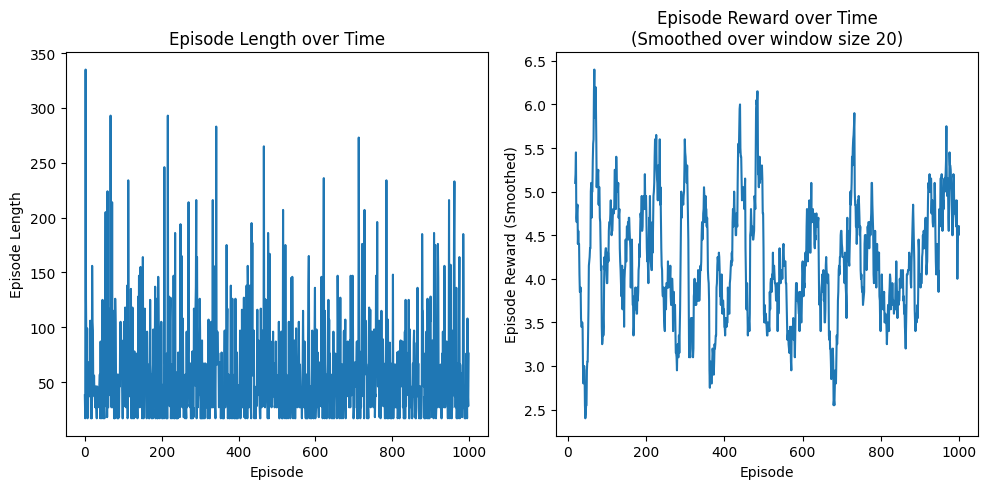

In [1099]:
smoothing_window=20
fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

# Plot the episode length over time
ax = axes[0]
ax.plot(stats.episode_lengths)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Length")
ax.set_title("Episode Length over Time")

# Plot the episode reward over time
ax = axes[1]
rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
ax.plot(rewards_smoothed)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Reward (Smoothed)")
ax.set_title(f"Episode Reward over Time\n(Smoothed over window size {smoothing_window})")
plt.show()

Lastly, let us see what the learned policy does in action.

c:\Users\Akademiker\miniconda3\envs\rl_lab\lib\site-packages\gymnasium\utils\passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
c:\Users\Akademiker\miniconda3\envs\rl_lab\lib\site-packages\gymnasium\utils\passive_env_checker.py:276: UserWarning: WARN: RGB-array rendering should return a numpy array with dtype uint8, got float64
  logger.warn(


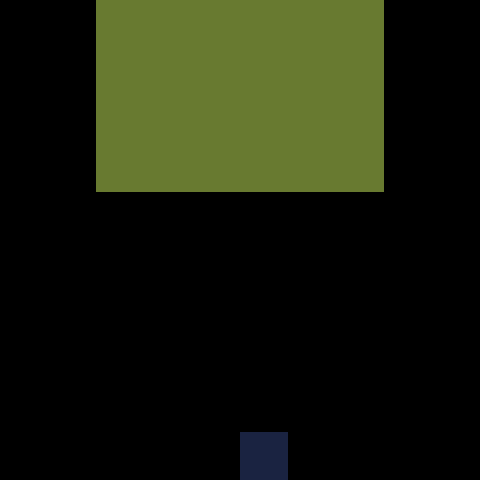

In [1100]:
from IPython.display import Image as IImage

def save_rgb_animation(rgb_arrays, filename, duration=50):
    """Save an animated GIF from a list of RGB arrays."""
    # Create a list to hold each frame
    frames = []

    # Convert RGB arrays to PIL Image objects
    for rgb_array in rgb_arrays:
        rgb_array = (rgb_array*255).astype(np.uint8)
        rgb_array = rgb_array.repeat(48, axis=0).repeat(48, axis=1)
        img = Image.fromarray(rgb_array)
        frames.append(img)

    # Save the frames as an animated GIF
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)

def rendered_rollout(policy, env, max_steps=1_000):
    """Rollout for one episode while saving all rendered images."""
    obs, _ = env.reset()
    imgs = [env.render()]

    for _ in range(max_steps):
        action = policy(torch.as_tensor(obs, dtype=torch.float32).unsqueeze(0))
        obs, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())

        if terminated or truncated:
            break

    return imgs

policy = make_epsilon_greedy_policy(agent.q, num_actions=env.action_space.n)
imgs = rendered_rollout(policy, env)
save_rgb_animation(imgs, "trained.gif")
IImage(filename="trained.gif")